In [1]:
import os
import re

In [2]:
!pip install pandas

In [17]:
import pandas as pd
!pip install matplotlib
import matplotlib.pyplot as plt

  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)


In [83]:
# !pip install psycopg2
# import psycopg2

In [84]:
# %load_ext sql

# TASK 1

In [3]:
HOST = "localhost"
DB = "tweetsDB"
USER = "postgres"
PASSWD = "passwd"

In [86]:
# conn = psycopg2.connect(dbname=DB, user=USER, password=PASSWD, host=HOST)

In [87]:
# cur = conn.cursor()

In [88]:
# cur.execute(query)

In [89]:
# cur.fetchall()

In [90]:
# res = cur.execute("SELECT * FROM hashtags LIMIT 100")

In [91]:
# print(res)

In [4]:
from sqlalchemy import create_engine
from sqlalchemy import Table, Column, String, Integer, MetaData
from sqlalchemy.orm import declarative_base, sessionmaker

In [5]:
posgres_conn_str = f"postgresql://{USER}:{PASSWD}@{HOST}/{DB}"

In [6]:
engine = create_engine(posgres_conn_str)

# TASK 2

TODO:

    1. vytvorit si novy stlpec pre sentiment(neg, neu, pos, compound)
    2. joinut tweety s tweethashtagmi s hashtagmi 
    3. vyfiltrovat podla danych hashtagov, ktore chcem 
    4. vypocitat sentiment a zapisat do DB

Adding the sentiment columns to the tweets table

In [266]:
add_columns_query = """

    BEGIN TRAN 

    ALTER TABLE tweets
    ADD COLUMN neg numeric(6, 4),
    ADD COLUMN neu numeric(6, 4),
    ADD COLUMN pos numeric(6, 4),
    ADD COLUMN compound numeric(6, 4)

    COMMIT TRAN 

"""

In [8]:
try:
    engine.execute(add_columns_query)
    engine.commit()
except:
    print("Columns probably already exist")

Columns probably already exist


In [8]:
HASHTAG_FILTER = """'%%DeepstateVirus%%', '%%DeepStateVaccine%%','%%DeepStateFauci%%', '%%QAnon%%', '%%Agenda21%%', '%%CCPVirus%%', '%%ClimateChangeHoax%%',
'%%GlobalWarmingHoax%%', '%%ChinaLiedPeopleDied%%', '%%SorosVirus%%', '%%5GCoronavirus%%', '%%MAGA%%',
'%%WWG1WGA%%', '%%Chemtrails%%', '%%flatEarth%%', '%%MoonLandingHoax%%', '%%moonhoax%%', '%%illuminati%%',
'%%pizzaGateIsReal%%', '%%PedoGateIsReal%%', '%%911truth%%', '%%911insidejob%%', '%%reptilians%%'"""

In [7]:
# hashtag : conspiracy_theory
CONSPIRACY_THEORIES = {
 
        "deepstatevirus"                :   "Deep State",  
        "deepstatevaccine"              :   "Deep State",
        "deepstatefauci"                :   "Deep State",
        "qanon"                         :   "Qanon",
        "maga"                          :   "Qanon",
        "wwg1wga"                       :   "Qanon",
        "agenda21"                      :   "New world order",
        "ccpvirus"                      :   "The virus escaped from a Chinese lab", 
        "chinaliedpeopledied"           :   "The virus escaped from a Chinese lab",
        "climatechangehoax"             :   "GLobal Warming is HOAX",
        "globalwarminghoax"             :   "GLobal Warming is HOAX",
        "sorosvirus"                    :   "COVID19 and microchipping", 
        "billgates"                     :   "COVID19 and microchipping",
        "5gcoronavirus"                 :   "COVID19 is preaded by 5G",
        "moonlandinghoax"               :   "Moon landing is fake", 
        "moonhoax"                      :   "Moon landing is fake",
        "911truth"                      :   "9/11 was inside job",
        "911insidejob"                  :   "9/11 was inside job",
        "pizzagateisreal"               :   "Pizzagate conspiracy theory",
        "pedogateisreal"                :   "Pizzagate conspiracy theory",   
        "chemtrails"                    :   "Chemtrails",
        "flatearth"                     :   "FlatEarth",
        "illuminati"                    :   "Illuminati",
        "reptilians"                    :   "Reptilian conspiracy theory"
}

In [8]:
CONSPIRACY_THEORIES.get("DeepStateVaccine")

We need to match all the mutations of the hashtags:

In [16]:
filter_query = f"""
    SELECT * 
    FROM hashtags
    WHERE lower(value) LIKE ANY (array[{HASHTAG_FILTER.lower()}])
"""

In [14]:
filter_query

"\n    SELECT * \n    FROM hashtags\n    WHERE lower(value) LIKE ANY (array['%%deepstatevirus%%', '%%deepstatevaccine%%','%%deepstatefauci%%', '%%qanon%%', '%%agenda21%%', '%%ccpvirus%%', '%%climatechangehoax%%',\n'%%globalwarminghoax%%', '%%chinaliedpeopledied%%', '%%sorosvirus%%', '%%5gcoronavirus%%', '%%maga%%',\n'%%wwg1wga%%', '%%chemtrails%%', '%%flatearth%%', '%%moonlandinghoax%%', '%%moonhoax%%', '%%illuminati%%',\n'%%pizzagateisreal%%', '%%pedogateisreal%%', '%%911truth%%', '%%911insidejob%%', '%%reptilians%%'])\n"

In [274]:
qanon_query = f"""
    SELECT * 
    FROM hashtags
    WHERE lower(value) LIKE ANY (array['qanon'])
"""

In [275]:
df_qanon = pd.read_sql(qanon_query, engine)

In [17]:
df_filtered = pd.read_sql(filter_query, engine)

In [18]:
df_filtered

,id,value
0,15690756,qANON
1,15696429,QanonDeutsch
2,15761297,WHMAGA
3,15789032,WWG1WGAWARRIORS
4,15806121,Pizzagateisreal
...,...,...
2013,66445,Agenda21
2014,3794870,WWG1WGAWorldWide
2015,158957,MAGA2020
2016,59789,MAGAts


In [278]:
df_qanon

,id,value
0,21259243,QAnON
1,15690756,qANON
2,15177935,qAnon
3,16799781,qanOn
4,18387797,QanON
5,27195,QANON
6,22837040,QanoN
7,25091,qanon
8,22849188,QanOn
9,15168832,QANOn


We can see that hoaxer dont know grammar

In [63]:
emoji_pat = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        # u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        # u"\U00002702-\U000027B0"
        # u"\U000024C2-\U0001F251"  # mandarinian chars
        u"\U00010000-\U0010ffff"
        u"\U0001f926-\U0001f937"
        u"\u2600-\u2B55"
        u"\u2640-\u2642" 
        u"\u200d"
        u"\u231a"
        u"\u23e9"
        u"\u23cf"
        u"\ufe0f"  # dingbats
        u"\u3030"
                        "]+", flags = re.UNICODE)




def parse_line(line):
    # res = re.sub("(\#|\@)[\w]+", "", line)
    res = re.sub("[#@]+[\w.-]*", "", line)
    res = emoji_pat.sub(r'',res)
    return res.lstrip().rstrip()

In [64]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()


def compute_sentiment_and_write(line):
    # parse the line and compute the sentiment
    id = line['id']
    sentiment = sid.polarity_scores(parse_line(line['content']))
    # print(parse_line(line['content']))
    # print(sid.polarity_scores(parse_line(line['content'])))
    try:
        engine.execute(f"""
            BEGIN TRAN 

            UPDATE tweets
            SET neg = {sentiment['neg']},
                neu = {sentiment['neu']},
                pos = {sentiment['pos']},
                compound = {sentiment['compound']}
            WHERE id = '{id}';

            COMMIT TRAN 
        """)
        
    except:
        print("Something went wrong during write")




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kdeni\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
lower_hastag_filter = HASHTAG_FILTER.lower()

In [13]:
lower_hastag_filter

"'%%deepstatevirus%%', '%%deepstatevaccine%%','%%deepstatefauci%%', '%%qanon%%', '%%agenda21%%', '%%ccpvirus%%', '%%climatechangehoax%%',\n'%%globalwarminghoax%%', '%%chinaliedpeopledied%%', '%%sorosvirus%%', '%%5gcoronavirus%%', '%%maga%%',\n'%%wwg1wga%%', '%%chemtrails%%', '%%flatearth%%', '%%moonlandinghoax%%', '%%moonhoax%%', '%%illuminati%%',\n'%%pizzagateisreal%%', '%%pedogateisreal%%', '%%911truth%%', '%%911insidejob%%', '%%reptilians%%'"

In [14]:
query = f"""
                SELECT tweets.id as tweetID, tweets.content, h.id as hashtagID, h.value as hashtagVal
                FROM tweets
                JOIN tweet_hashtags as th ON th.tweet_id = tweets.id
                JOIN hashtags as h ON h.id = th.hashtag_id
                WHERE lower(h.value) ILIKE ANY (array[{lower_hastag_filter}])
        
"""

In [24]:
query_hash = f"""
        SELECT value
        FROM hashtags as h
        WHERE lower(h.value) ILIKE ANY (array[{lower_hastag_filter}])
"""

In [24]:
query_hash

"\n        SELECT value\n        FROM hashtags as h\n        WHERE lower(h.value) ILIKE ANY (array['%%deepstatevirus%%', '%%deepstatevaccine%%','%%deepstatefauci%%', '%%qanon%%', '%%agenda21%%', '%%ccpvirus%%', '%%climatechangehoax%%',\n'%%globalwarminghoax%%', '%%chinaliedpeopledied%%', '%%sorosvirus%%', '%%5gcoronavirus%%', '%%maga%%',\n'%%wwg1wga%%', '%%chemtrails%%', '%%flatearth%%', '%%moonlandinghoax%%', '%%moonhoax%%', '%%illuminati%%',\n'%%pizzagateisreal%%', '%%pedogateisreal%%', '%%911truth%%', '%%911insidejob%%', '%%reptilians%%'])\n"

In [25]:
df_some = pd.read_sql(query_hash, engine)

In [26]:
df_some

,value
0,agenda21
1,keralalifemagazine
2,MAGAValentinesGifts
3,TrueMAGA
4,Magazines
...,...
2013,WWG1WGA
2014,MAGA
2015,QanonIsTruth
2016,QanonSharp


In [15]:
df_filtered_tweets = pd.read_sql(query, engine)

In [62]:
df_filtered_tweets['content'][20]

'Coronavirus, Organic or Purposely Released? https://t.co/URK2lIpxbV \n\n#WWG1WGA'

In [17]:
df_filtered_tweets['hashtagval'] = df_filtered_tweets['hashtagval'].apply(lambda x: x.lower()) 

Remove duplicates

In [18]:
df_unique_filtered_tweets = df_filtered_tweets.drop_duplicates(subset=['tweetid'])

In [38]:
df_unique_filtered_tweets["content"][995]

'RT @alireza_areff: 中国人民需要知道，过去几十年来，中国政府通过支持伊朗的恐怖主义政权向伊朗发送了#Coronavirus。\n 伊朗政权已经用中国政府付给他们的钱杀死并监禁了数百人。\n #MAGA #MIGA https://t.co/A0tRIavjDP\n#…'

In [20]:
df_filtered_tweets

,tweetid,content,hashtagid,hashtagval
0,1220491726214717440,I didn't say a word about #QAnon in my tweets ...,20506,qanon
1,1220786014006009856,Update: #Coronavirus Is Spreading In The US No...,14415,maga
2,1220789297474916355,@being_nontheist @SenatorDurbin @Lawrence @Sen...,18287,wwg1wga_worldwide
3,1220797748502417409,RT @Jordan_Sather_: I didn't say a word about ...,20506,qanon
4,1220796328265101312,RT @Jordan_Sather_: I didn't say a word about ...,20506,qanon
...,...,...,...,...
3656137,1255962361866878986,The ugly face of the #CCP hidden behind the #C...,1137275,ccpvirus
3656138,1256433969240956932,Toutes les innovations du CES 2020 🙂😊👌🏾🔥... si...,15552438,5gcoronavirus
3656139,1256462861343141888,Happy day! #saturdayvibes #weekendfun #weekend...,36548271,ritzmagazine
3656140,1256462924719239168,Hey #lockdown #protest ers. The ice is danger...,14415,maga


In [23]:
filtered = df_filtered_tweets.apply(lambda x: parse_line(x['content']), axis=1)

In [26]:
type(filtered)

pandas.core.series.Series

Computing the sentiment and writing it to the db

In [255]:
id_count = len(df_filtered_tweets)

In [316]:
df_unique_filtered_tweets.apply(lambda x: compute_sentiment_and_write(x), axis=1)

0          None
1          None
2          None
3          None
4          None
           ... 
3656131    None
3656133    None
3656134    None
3656135    None
3656140    None
Length: 2152424, dtype: object

In [246]:
# for (id, sentiment) in new_col:

#     engine.execute(f"""
#         UPDATE tweets
#         SET neg = {sentiment['neg']},
#             neu = {sentiment['neu']},
#             pos = {sentiment['pos']},
#             compound = {sentiment['compound']}
#         WHERE id = '{id}';
#     """)


# TASK 3

Creating the consp_theory tables as well the link between hashtags and consptheory

In [32]:
consp_theory_link = df_filtered_tweets.loc[ : , ["hashtagid", "hashtagval", "tweetid"]]

In [33]:
consp_theory_link

,hashtagid,hashtagval,tweetid
0,14415,maga,1220786014006009856
1,14415,maga,1220728654327664640
2,18287,wwg1wga_worldwide,1220789297474916355
3,20506,qanon,1220796328265101312
4,14415,maga,1220796147759026176
...,...,...,...
3656137,1137275,ccpvirus,1255962361866878986
3656138,3073063,ccpvirus,1256457162148233219
3656139,15552438,5gcoronavirus,1256433969240956932
3656140,14415,maga,1256462924719239168


In [34]:
consp_theory_link = consp_theory_link.drop_duplicates()

In [35]:
consp_theory_link

,hashtagid,hashtagval,tweetid
0,14415,maga,1220786014006009856
1,14415,maga,1220728654327664640
2,18287,wwg1wga_worldwide,1220789297474916355
3,20506,qanon,1220796328265101312
4,14415,maga,1220796147759026176
...,...,...,...
3656137,1137275,ccpvirus,1255962361866878986
3656138,3073063,ccpvirus,1256457162148233219
3656139,15552438,5gcoronavirus,1256433969240956932
3656140,14415,maga,1256462924719239168


In [36]:
consp_theory_link[consp_theory_link['tweetid'] == str(1256801279139069952)]

,hashtagid,hashtagval,tweetid
18393,20506,qanon,1256801279139069952
18394,15171991,chemtrails,1256801279139069952
18395,25089,wwg1wga,1256801279139069952
18396,259500,wwg1wgaworldwide,1256801279139069952


In [37]:
consp_theory_link = consp_theory_link.reset_index(drop=True)

In [50]:
consp_theory_link

,hashtagid,hashtagval,tweetid
0,14415,maga,1220786014006009856
1,14415,maga,1220728654327664640
2,18287,wwg1wga_worldwide,1220789297474916355
3,20506,qanon,1220796328265101312
4,14415,maga,1220796147759026176
...,...,...,...
3656137,1137275,ccpvirus,1255962361866878986
3656138,3073063,ccpvirus,1256457162148233219
3656139,15552438,5gcoronavirus,1256433969240956932
3656140,14415,maga,1256462924719239168


In [33]:
CONSPIRACY_THEORIES.get(consp_theory_link['hashtagval'][2015])

'Qanon'

In [34]:
CONSPIRACY_THEORIES.get("some")

In [35]:
consp_theory_link['hashtagval'][2015]

'wwg1wga'

Get the name of the consp. theory.

In [51]:
consp_theory_link

,hashtagid,hashtagval,tweetid
0,14415,maga,1220786014006009856
1,14415,maga,1220728654327664640
2,18287,wwg1wga_worldwide,1220789297474916355
3,20506,qanon,1220796328265101312
4,14415,maga,1220796147759026176
...,...,...,...
3656137,1137275,ccpvirus,1255962361866878986
3656138,3073063,ccpvirus,1256457162148233219
3656139,15552438,5gcoronavirus,1256433969240956932
3656140,14415,maga,1256462924719239168


In [9]:
CONSPIRACY_THEORIES_LIST = list(CONSPIRACY_THEORIES.keys())
THEORY_LIST = list(set(CONSPIRACY_THEORIES.values()))

def chceck_theory(hashtag):
    for key in CONSPIRACY_THEORIES_LIST:
        if key in hashtag:
            return CONSPIRACY_THEORIES.get(key)


Mapping the hashtag to the theory name.

In [53]:
# consp_theory_link['theory'] = consp_theory_link.apply(lambda x: CONSPIRACY_THEORIES.get(x["hashtagval"]), axis=1)
consp_theory_link['theory'] = consp_theory_link.apply(lambda x: chceck_theory(x['hashtagval']), axis=1)

In [54]:
consp_theory_link

,hashtagid,hashtagval,tweetid,theory
0,14415,maga,1220786014006009856,Qanon
1,14415,maga,1220728654327664640,Qanon
2,18287,wwg1wga_worldwide,1220789297474916355,Qanon
3,20506,qanon,1220796328265101312,Qanon
4,14415,maga,1220796147759026176,Qanon
...,...,...,...,...
3656137,1137275,ccpvirus,1255962361866878986,The virus escaped from a Chinese lab
3656138,3073063,ccpvirus,1256457162148233219,The virus escaped from a Chinese lab
3656139,15552438,5gcoronavirus,1256433969240956932,COVID19 is preaded by 5G
3656140,14415,maga,1256462924719239168,Qanon


In [55]:
consp_values = list(set(CONSPIRACY_THEORIES.values()))

In [59]:
id_arr = [x for x in range(1, len(consp_values) + 1)]

In [60]:
# id_arr

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [61]:
consp_theory_tab = pd.DataFrame(list(zip(id_arr, consp_values)), columns=["id", "theory_name"])

In [62]:
consp_theory_tab

,id,theory_name
0,1,COVID19 and microchipping
1,2,Moon landing is fake
2,3,Chemtrails
3,4,Reptilian conspiracy theory
4,5,COVID19 is preaded by 5G
5,6,The virus escaped from a Chinese lab
6,7,Qanon
7,8,GLobal Warming is HOAX
8,9,FlatEarth
9,10,New world order


In [304]:
try:
    engine.execute("""
        BEGIN TRAN 

        CREATE TABLE IF NOT EXISTS consp_theories (
        id INT GENERATED ALWAYS AS IDENTITY,
        theory_name varchar(255),
        PRIMARY KEY(id)
    );   

        COMMIT TRAN 
    """)
except:
    print("Something went wrong")

Inserting the consp_theories

In [305]:
try:
    for _, row in consp_theory_tab.iterrows():
        engine.execute(f"""
            BEGIN TRAN 
            INSERT INTO consp_theories(theory_name)
            VALUES ('{row['theory_name']}');
            COMMIT TRAN   
        """)
except:
    print("Somthing went wrong")

In [64]:
df_theories = pd.read_sql(
    """
    SELECT id, theory_name
    FROM 
    consp_theories
    """
    , engine)

In [65]:
df_theories['theory_name']

0                      9/11 was inside job
1     The virus escaped from a Chinese lab
2              Reptilian conspiracy theory
3                               Chemtrails
4                   GLobal Warming is HOAX
5              Pizzagate conspiracy theory
6                          New world order
7                                    Qanon
8                               Deep State
9                     Moon landing is fake
10                              Illuminati
11                COVID19 is preaded by 5G
12               COVID19 and microchipping
13                               FlatEarth
Name: theory_name, dtype: object

In [66]:
df_theories

,id,theory_name
0,1,9/11 was inside job
1,2,The virus escaped from a Chinese lab
2,3,Reptilian conspiracy theory
3,4,Chemtrails
4,5,GLobal Warming is HOAX
5,6,Pizzagate conspiracy theory
6,7,New world order
7,8,Qanon
8,9,Deep State
9,10,Moon landing is fake


In [67]:
mapping_dict = dict(zip(df_theories['theory_name'], df_theories['id']))

In [68]:
mapping_dict

{'9/11 was inside job': 1,
 'The virus escaped from a Chinese lab': 2,
 'Reptilian conspiracy theory': 3,
 'Chemtrails': 4,
 'GLobal Warming is HOAX': 5,
 'Pizzagate conspiracy theory': 6,
 'New world order': 7,
 'Qanon': 8,
 'Deep State': 9,
 'Moon landing is fake': 10,
 'Illuminati': 11,
 'COVID19 is preaded by 5G': 12,
 'COVID19 and microchipping': 13,
 'FlatEarth': 14}

In [69]:
consp_theory_link['theory_id'] = consp_theory_link.apply(lambda x: mapping_dict.get(x['theory']), axis=1)

In [70]:
consp_theory_link

,hashtagid,hashtagval,tweetid,theory,theory_id
0,14415,maga,1220786014006009856,Qanon,8
1,14415,maga,1220728654327664640,Qanon,8
2,18287,wwg1wga_worldwide,1220789297474916355,Qanon,8
3,20506,qanon,1220796328265101312,Qanon,8
4,14415,maga,1220796147759026176,Qanon,8
...,...,...,...,...,...
3656137,1137275,ccpvirus,1255962361866878986,The virus escaped from a Chinese lab,2
3656138,3073063,ccpvirus,1256457162148233219,The virus escaped from a Chinese lab,2
3656139,15552438,5gcoronavirus,1256433969240956932,COVID19 is preaded by 5G,12
3656140,14415,maga,1256462924719239168,Qanon,8


In [71]:
hash_consp_mapping = consp_theory_link.loc[:, ['hashtagid', 'theory_id']]

In [72]:
hash_consp_mapping = hash_consp_mapping.drop_duplicates(subset=['hashtagid'])

In [73]:
hash_consp_mapping.dtypes

hashtagid    int64
theory_id    int64
dtype: object

In [74]:
hash_consp_mapping

,hashtagid,theory_id
0,14415,8
2,18287,8
3,20506,8
8,25089,8
9,24818,8
...,...,...
3655885,37283281,8
3655889,37295422,8
3655979,37375431,8
3656027,37408594,8


In [75]:
hash_consp_mapping['hashtagid'] = hash_consp_mapping['hashtagid'].astype(int)
hash_consp_mapping = hash_consp_mapping.dropna()
hash_consp_mapping['theory_id'] = hash_consp_mapping['theory_id'].astype(int)

In [76]:
hash_consp_mapping

,hashtagid,theory_id
0,14415,8
2,18287,8
3,20506,8
8,25089,8
9,24818,8
...,...,...
3655885,37283281,8
3655889,37295422,8
3655979,37375431,8
3656027,37408594,8


Adding the mapping between theories and hashtags

In [79]:
try:
    engine.execute("""
        BEGIN;

        CREATE TABLE IF NOT EXISTS hash_consptheories_link (
        id int GENERATED ALWAYS AS IDENTITY,
        hashtag_id int,
        consp_theory_id int,
        PRIMARY KEY(id),
        CONSTRAINT fk_hashtag
            FOREIGN KEY(hashtag_id)
                REFERENCES hashtags(id)
                ON DELETE SET NULL,

        CONSTRAINT fk_consptheory        
            FOREIGN KEY(consp_theory_id)
                REFERENCES consp_theories(id)
                ON DELETE SET NULL
    );  

    COMMIT; 
    """)
    
except:
    print("Something went wrong")

In [80]:
try:
    for _, row in hash_consp_mapping.iterrows():
        # print(row['theory_name'])
        engine.execute(f"""
            BEGIN;
            INSERT INTO hash_consptheories_link(hashtag_id, consp_theory_id)
            VALUES ('{int(row['hashtagid'])}', '{int(row['theory_id'])}');
            COMMIT;
        """)
#         # consp_theory_tab.to_sql('consp_theories', engine, if_exists='replace', index=False)
except:
    print("Somthing went wrong")

# TASK 4

In [ ]:
print("Something")

In [10]:
sentiment_query = """
    SELECT res.theory, res.week, count(res.compound) as tweet_count, sum(abs(res.compound)) as tweet_extreme_count, sum(abs(res.neu)) as tweet_neutral_count
    FROM 
    (
        SELECT tweets.compound, tweets.neu, EXTRACT(WEEK from tweets.happened_at) as week, ct.theory_name as theory
            FROM tweets
            JOIN tweet_hashtags as th ON th.tweet_id = tweets.id
            JOIN hashtags as h ON h.id = th.hashtag_id
            JOIN hash_consptheories_link as hcl ON hcl.hashtag_id = h.id
            JOIN consp_theories as ct ON ct.id = hcl.consp_theory_id
            WHERE tweets.compound NOT BETWEEN (-0.5) AND (0.5)
            group by (ct.theory_name, week, tweets.compound, tweets.neu)
        ) as res
        
    GROUP BY (res.week, res.theory)
    ORDER BY res.theory
"""

In [12]:
try:
    df_week_extreme_comp = pd.read_sql(sentiment_query, engine)
except:
    print("Something went wrong")

In [13]:
df_week_extreme_comp

,theory,week,tweet_count,tweet_extreme_count,tweet_neutral_count
0,9/11 was inside job,5.0,1,0.5574,0.662
1,9/11 was inside job,8.0,1,0.6486,0.654
2,9/11 was inside job,15.0,3,1.9305,2.405
3,9/11 was inside job,16.0,2,1.1513,1.524
4,9/11 was inside job,18.0,4,2.9012,2.837
...,...,...,...,...,...
147,The virus escaped from a Chinese lab,18.0,194,133.9077,135.210
148,The virus escaped from a Chinese lab,19.0,122,84.1172,86.548
149,The virus escaped from a Chinese lab,20.0,62,44.4345,45.342
150,The virus escaped from a Chinese lab,21.0,3,2.0589,2.032


In [14]:
df_week_extreme_comp['week'] = df_week_extreme_comp['week'].astype(int)


    #######
    ---  9/11 was inside job ---
    ######
                    theory  week  tweet_count  tweet_extreme_count  \
0  9/11 was inside job     5            1               0.5574   
1  9/11 was inside job     8            1               0.6486   
2  9/11 was inside job    15            3               1.9305   
3  9/11 was inside job    16            2               1.1513   
4  9/11 was inside job    18            4               2.9012   
5  9/11 was inside job    19            2               1.4732   
6  9/11 was inside job    22            2               1.1809   

   tweet_neutral_count  
0                0.662  
1                0.654  
2                2.405  
3                1.524  
4                2.837  
5                1.481  
6                1.744  


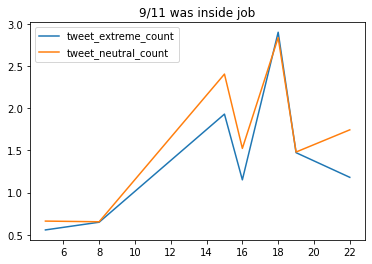


    #######
    ---  Reptilian conspiracy theory ---
    ######
                              theory  week  tweet_count  tweet_extreme_count  \
134  Reptilian conspiracy theory    15            1               0.5411   
135  Reptilian conspiracy theory    16            4               2.5827   
136  Reptilian conspiracy theory    17            3               1.8625   
137  Reptilian conspiracy theory    18            3               1.7777   

     tweet_neutral_count  
134                0.889  
135                2.377  
136                2.050  
137                2.300  


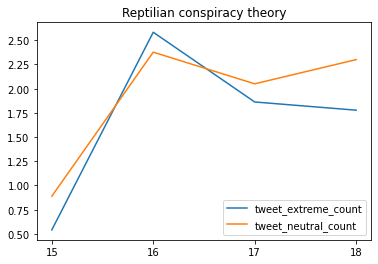


    #######
    ---  Illuminati ---
    ######
            theory  week  tweet_count  tweet_extreme_count  tweet_neutral_count
52  Illuminati     4            3               1.9221                2.474
53  Illuminati     5            5               3.3874                3.838
54  Illuminati     6            2               1.4242                1.511
55  Illuminati     7            1               0.7783                0.562
56  Illuminati     9            1               0.5983                0.770
57  Illuminati    14           17              11.4019               12.177
58  Illuminati    15           24              15.4397               17.638
59  Illuminati    16           61              42.0136               40.041
60  Illuminati    17           32              21.9661               22.649
61  Illuminati    18           31              20.4414               21.545
62  Illuminati    19           18              12.3820               12.633
63  Illuminati    20           30   

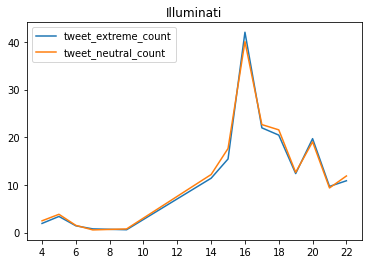


    #######
    ---  COVID19 is preaded by 5G ---
    ######
                          theory  week  tweet_count  tweet_extreme_count  \
8   COVID19 is preaded by 5G    13            1               0.7906   
9   COVID19 is preaded by 5G    14           20              14.8629   
10  COVID19 is preaded by 5G    15           15               9.6164   
11  COVID19 is preaded by 5G    16           10               6.9002   
12  COVID19 is preaded by 5G    17           18              12.5142   
13  COVID19 is preaded by 5G    18            5               3.1945   
14  COVID19 is preaded by 5G    19            5               3.5575   

    tweet_neutral_count  
8                 0.759  
9                13.249  
10               11.349  
11                7.440  
12               12.660  
13                3.308  
14                3.473  


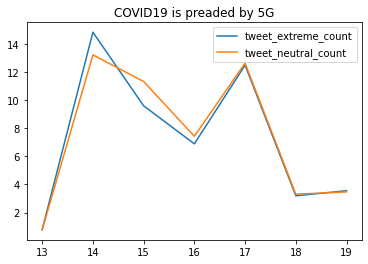


    #######
    ---  COVID19 and microchipping ---
    ######
                          theory  week  tweet_count  tweet_extreme_count  \
7  COVID19 and microchipping     8            2               1.3113   

   tweet_neutral_count  
7                1.639  


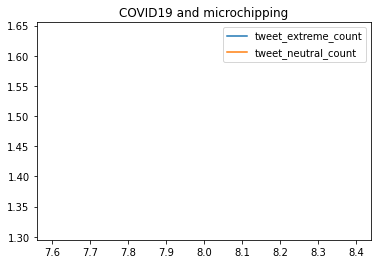


    #######
    ---  FlatEarth ---
    ######
           theory  week  tweet_count  tweet_extreme_count  tweet_neutral_count
22  FlatEarth     5            4               2.7525                2.933
23  FlatEarth     6            1               0.5423                0.791
24  FlatEarth     7            2               1.1578                1.624
25  FlatEarth     9            1               0.6369                0.538
26  FlatEarth    14            3               2.0342                2.151
27  FlatEarth    15            4               2.5083                2.927
28  FlatEarth    16            6               3.7609                3.917
29  FlatEarth    17            5               3.2380                3.656
30  FlatEarth    18            9               6.4276                5.454
31  FlatEarth    19            5               3.5315                3.756
32  FlatEarth    20            4               2.7973                2.817
33  FlatEarth    21           13               9.

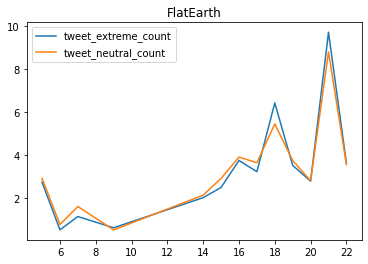


    #######
    ---  Moon landing is fake ---
    ######
                      theory  week  tweet_count  tweet_extreme_count  \
66  Moon landing is fake    16            1               0.5267   
67  Moon landing is fake    19            1               0.5267   
68  Moon landing is fake    20            3               1.6864   
69  Moon landing is fake    21            1               0.6330   
70  Moon landing is fake    22            1               0.6330   

    tweet_neutral_count  
66                0.793  
67                0.793  
68                2.334  
69                0.736  
70                0.736  


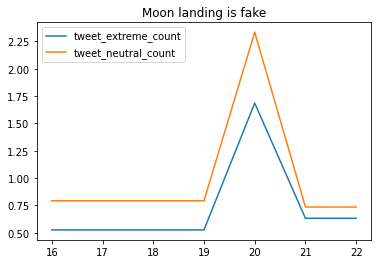


    #######
    ---  Pizzagate conspiracy theory ---
    ######
                             theory  week  tweet_count  tweet_extreme_count  \
87  Pizzagate conspiracy theory     6            1               0.7456   
88  Pizzagate conspiracy theory    13            1               0.5994   
89  Pizzagate conspiracy theory    14           16              10.9498   
90  Pizzagate conspiracy theory    15           40              27.9273   
91  Pizzagate conspiracy theory    16           56              37.4588   
92  Pizzagate conspiracy theory    17           22              14.9257   
93  Pizzagate conspiracy theory    18           59              41.0528   
94  Pizzagate conspiracy theory    19           17              11.5674   
95  Pizzagate conspiracy theory    20           36              25.8145   
96  Pizzagate conspiracy theory    21           27              18.7960   
97  Pizzagate conspiracy theory    22           30              20.7903   
98  Pizzagate conspiracy theory

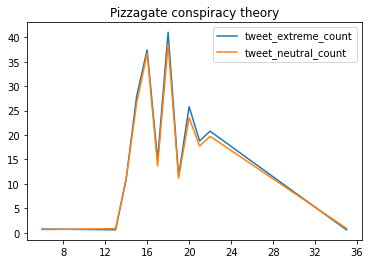


    #######
    ---  GLobal Warming is HOAX ---
    ######
                        theory  week  tweet_count  tweet_extreme_count  \
35  GLobal Warming is HOAX     5            7               5.3672   
36  GLobal Warming is HOAX     6            5               3.4048   
37  GLobal Warming is HOAX     8            1               0.8504   
38  GLobal Warming is HOAX     9            1               0.7506   
39  GLobal Warming is HOAX    20            2               1.2171   

    tweet_neutral_count  
35                4.901  
36                2.845  
37                0.776  
38                0.841  
39                1.721  


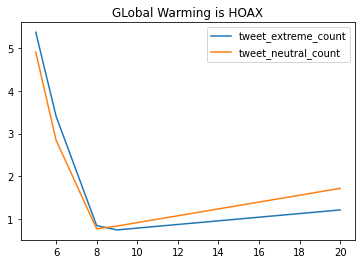


    #######
    ---  New world order ---
    ######
                 theory  week  tweet_count  tweet_extreme_count  \
71  New world order     4           49              35.9823   
72  New world order     5          109              83.6998   
73  New world order     6           14               9.9676   
74  New world order     7           11               7.2734   
75  New world order     8            3               2.3242   
76  New world order     9            3               2.0026   
77  New world order    13            1               0.9837   
78  New world order    14           12               9.0131   
79  New world order    15           12               8.4736   
80  New world order    16           13               8.6432   
81  New world order    17            6               4.2131   
82  New world order    18           25              16.5278   
83  New world order    19           11               7.0858   
84  New world order    20           12               8.3512  

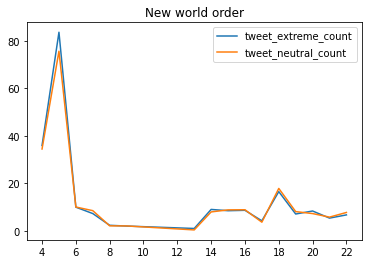


    #######
    ---  The virus escaped from a Chinese lab ---
    ######
                                       theory  week  tweet_count  \
138  The virus escaped from a Chinese lab     5            2   
139  The virus escaped from a Chinese lab     6            3   
140  The virus escaped from a Chinese lab     7            2   
141  The virus escaped from a Chinese lab    12            5   
142  The virus escaped from a Chinese lab    13           16   
143  The virus escaped from a Chinese lab    14          314   
144  The virus escaped from a Chinese lab    15          346   
145  The virus escaped from a Chinese lab    16          367   
146  The virus escaped from a Chinese lab    17          266   
147  The virus escaped from a Chinese lab    18          194   
148  The virus escaped from a Chinese lab    19          122   
149  The virus escaped from a Chinese lab    20           62   
150  The virus escaped from a Chinese lab    21            3   
151  The virus escaped fro

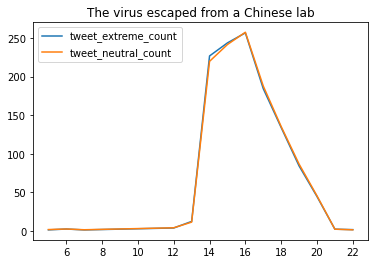


    #######
    ---  Deep State ---
    ######
            theory  week  tweet_count  tweet_extreme_count  tweet_neutral_count
15  Deep State    14            7               4.3740                5.557
16  Deep State    15           15              10.7336               10.746
17  Deep State    16            3               1.9520                1.708
18  Deep State    17            2               1.3866                1.360
19  Deep State    18            5               3.8928                3.627
20  Deep State    20            3               1.9042                2.450
21  Deep State    22            1               0.7003                0.616


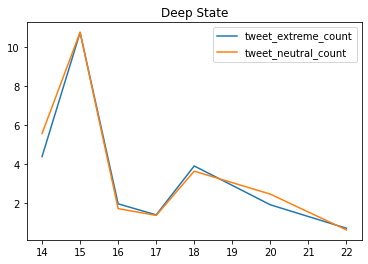


    #######
    ---  Qanon ---
    ######
        theory  week  tweet_count  tweet_extreme_count  tweet_neutral_count
99   Qanon     1            2               1.6505                1.337
100  Qanon     2            2               1.4133                1.661
101  Qanon     3            7               5.2349                5.346
102  Qanon     4          172             120.7142              123.171
103  Qanon     5          623             434.9803              440.100
104  Qanon     6          186             130.6491              130.072
105  Qanon     7          195             135.5065              137.476
106  Qanon     8          142              96.9784              101.983
107  Qanon     9          531             381.9842              372.379
108  Qanon    11            4               2.9022                2.820
109  Qanon    12            7               5.1702                5.061
110  Qanon    13           14               9.4866               10.835
111  Qanon    14 

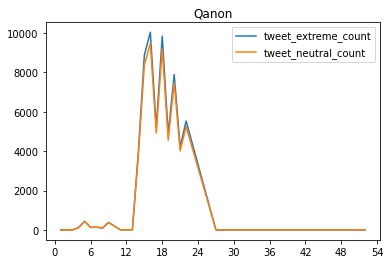


    #######
    ---  Chemtrails ---
    ######
            theory  week  tweet_count  tweet_extreme_count  tweet_neutral_count
40  Chemtrails     4            6               4.3413                4.160
41  Chemtrails     5            7               4.9236                4.948
42  Chemtrails     6            2               1.4709                1.351
43  Chemtrails    14            6               4.2059                4.084
44  Chemtrails    15           13               8.6714               10.106
45  Chemtrails    16           19              12.9334               14.018
46  Chemtrails    17            9               6.4129                5.721
47  Chemtrails    18            9               6.5098                6.425
48  Chemtrails    19            9               6.8293                6.823
49  Chemtrails    20           10               6.4989                6.628
50  Chemtrails    21            3               2.0360                2.319
51  Chemtrails    22            6   

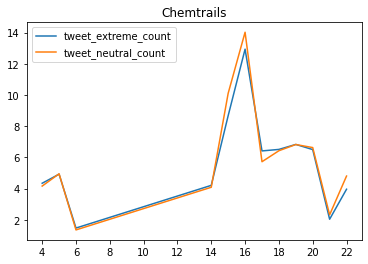

In [65]:
from matplotlib.ticker import MaxNLocator

for name in THEORY_LIST:
    print(f"""
    #######
    ---  {name} ---
    ######
    {df_week_extreme_comp[df_week_extreme_comp['theory'] == name]}""")


    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))


    ax.set_title(name)
  
    plt.plot(df_week_extreme_comp[df_week_extreme_comp['theory'] == name]['week'], 
        df_week_extreme_comp[df_week_extreme_comp['theory'] == name]['tweet_extreme_count'], label="tweet_extreme_count")
    
    plt.plot(df_week_extreme_comp[df_week_extreme_comp['theory'] == name]['week'], 
        df_week_extreme_comp[df_week_extreme_comp['theory'] == name]['tweet_neutral_count'], label="tweet_neutral_count")
    
    plt.legend()
    
    # show plot
    plt.show()
        
    

# TASK 5

In [92]:
accounts_query = """
    SELECT ct.theory_name, acc.id , acc.name, acc.screen_name, count(tweets.id) as tweet_count
    FROM tweets
    JOIN tweet_hashtags as th ON th.tweet_id = tweets.id
    JOIN hashtags as h ON h.id = th.hashtag_id
    JOIN hash_consptheories_link as hcl ON hcl.hashtag_id = h.id
    JOIN consp_theories as ct ON ct.id = hcl.consp_theory_id
    JOIN tweet_mentions as tm ON tm.tweet_id = tweets.id
    JOIN accounts as acc ON tm.account_id = acc.id
    WHERE tweets.compound NOT BETWEEN (-0.5) AND (0.5)
    group by (ct.theory_name, acc.id, acc.name, acc.screen_name)
    ORDER BY ct.theory_name ASC
"""

In [93]:
try:
    df_top_accounts_for_consp = pd.read_sql(accounts_query, engine)
except:
    print("Something went wrong")

In [94]:
df_top_accounts_for_consp

,theory_name,id,name,screen_name,tweet_count
0,9/11 was inside job,14499829,World Health Organization (WHO),WHO,1
1,9/11 was inside job,55905770,Miriam Selmi Reed,mimiselmi,2
2,9/11 was inside job,2213750137,Madeleine Stäubli,MadeleineRodun,1
3,9/11 was inside job,1173334893104967682,Anonymous Busch,AnonymousBusch,1
4,COVID19 and microchipping,23125257,George Soros,georgesoros,1
...,...,...,...,...,...
3870,The virus escaped from a Chinese lab,1381803231739846658,Vincent Wong,initialvw,1
3871,The virus escaped from a Chinese lab,1405060253159497730,The Core,SocialM85897394,1
3872,The virus escaped from a Chinese lab,1405799406113157128,Wesley Fangnats,WesFangNats,1
3873,The virus escaped from a Chinese lab,1407004701682454529,Leaih,leaih,1


In [96]:
df_top_accounts_for_consp = df_top_accounts_for_consp.sort_values(['theory_name', 'tweet_count'], ascending=[False, False])

In [97]:
df_top_accounts_for_consp

,theory_name,id,name,screen_name,tweet_count
3608,The virus escaped from a Chinese lab,2313027666,Jennifer Zeng 曾錚,jenniferatntd,113
3572,The virus escaped from a Chinese lab,1339488762,Solomon Yue,SolomonYue,96
3128,The virus escaped from a Chinese lab,14499829,World Health Organization (WHO),WHO,95
3224,The virus escaped from a Chinese lab,25073877,Donald J. Trump,realDonaldTrump,65
3833,The virus escaped from a Chinese lab,1232414456589750272,China in Focus - NTD,ChinaInFocusNTD,61
...,...,...,...,...,...
5,COVID19 and microchipping,188363529,"Alexander Soros, PhD",AlexanderSoros,1
1,9/11 was inside job,55905770,Miriam Selmi Reed,mimiselmi,2
0,9/11 was inside job,14499829,World Health Organization (WHO),WHO,1
2,9/11 was inside job,2213750137,Madeleine Stäubli,MadeleineRodun,1


In [98]:
for name in THEORY_LIST:
    print(f"""
    #######
    ---  {name} ---
    ######
    {df_top_accounts_for_consp[df_top_accounts_for_consp['theory_name'] == name].loc[ :, ['id', 'name', 'screen_name', 'tweet_count']].head(10)}""")


    #######
    ---  9/11 was inside job ---
    ######
                        id                             name     screen_name  \
1             55905770                Miriam Selmi Reed       mimiselmi   
0             14499829  World Health Organization (WHO)             WHO   
2           2213750137                Madeleine Stäubli  MadeleineRodun   
3  1173334893104967682                  Anonymous Busch  AnonymousBusch   

   tweet_count  
1            2  
0            1  
2            1  
3            1  

    #######
    ---  FlatEarth ---
    ######
                        id                 name      screen_name  tweet_count
48  929387229880946688         Jack William    Jackszooquest            4
37            25073877      Donald J. Trump  realDonaldTrump            2
35            10228272              YouTube          YouTube            1
36            17471979  National Geographic           NatGeo            1
38            38190348               Daniel  crimesceneve

# TASK 6

In [52]:
hash_tags_query = """
SELECT ct.theory_name, res.value as hashtag_val, sum(res.tweet_count) as tweet_count
FROM
	(SELECT h.id, h.value, count(distinct(tweets.id)) as tweet_count
	FROM tweets
	JOIN tweet_hashtags as th ON th.tweet_id = tweets.id
	JOIN hashtags as h ON h.id = th.hashtag_id
	JOIN hash_consptheories_link as hcl ON hcl.hashtag_id = h.id
	JOIN consp_theories as ct ON ct.id = hcl.consp_theory_id
	WHERE tweets.compound NOT BETWEEN (-0.5) AND (0.5)
	group by (h.id)
	ORDER BY h.value ASC) as res

JOIN hash_consptheories_link as hcl ON hcl.hashtag_id = res.id
JOIN consp_theories as ct ON ct.id = hcl.consp_theory_id
GROUP BY (ct.theory_name, res.id, res.value)
ORDER BY ct.theory_name ASC
"""

In [53]:
try:
    df_top_hashtags_for_consp = pd.read_sql(hash_tags_query, engine)
except:
    print("Something went wrong")

In [54]:
df_top_hashtags_for_consp = df_top_hashtags_for_consp.sort_values(['theory_name', 'tweet_count'], ascending=[False, False])
df_top_hashtags_for_consp['tweet_count'] = df_top_hashtags_for_consp['tweet_count'].astype(int)

In [55]:
df_top_hashtags_for_consp[df_top_hashtags_for_consp['theory_name'] == "The virus escaped from a Chinese lab"].head(10)

,theory_name,hashtag_val,tweet_count
883,The virus escaped from a Chinese lab,CCPVirus,1303
884,The virus escaped from a Chinese lab,ChinaLiedPeopleDied,954
881,The virus escaped from a Chinese lab,CCPvirus,151
885,The virus escaped from a Chinese lab,ccpvirus,26
889,The virus escaped from a Chinese lab,CCPVirus_Coronavirus,24
886,The virus escaped from a Chinese lab,chinaliedpeopledied,9
888,The virus escaped from a Chinese lab,CCPVIRUS,7
882,The virus escaped from a Chinese lab,ccpVirus,3
887,The virus escaped from a Chinese lab,CCPVirusHoax,3
894,The virus escaped from a Chinese lab,CCPVirusIsReal,2


In [58]:
for name in THEORY_LIST:
    print(f"""
    #######
    ---  {name} ---
    ######
    {df_top_hashtags_for_consp[df_top_hashtags_for_consp['theory_name'] == name].loc[ :, ['hashtag_val', 'tweet_count']].head(10)}""")


    #######
    ---  9/11 was inside job ---
    ######
           hashtag_val  tweet_count
0         911Truth           24
1         911truth            8
2         911Truth            2
3     911insidejob            2
4  911insidejobber            1

    #######
    ---  FlatEarth ---
    ######
              hashtag_val  tweet_count
15          FlatEarth           47
14          flatearth           23
18  researchflatearth           11
16          FLATEARTH            6
21        FlatEarther            3
23   flatearthsociety            3
25   FlatEarthSociety            3
17  ResearchFlatEarth            2
24       flatearthers            2
13       FlatEarthers            1

    #######
    ---  Qanon ---
    ######
             hashtag_val  tweet_count
74             QAnon       415088
76           WWG1WGA       200215
82             Qanon       128874
72              MAGA        70332
77             qanon        65261
78             QANON        56806
92  WWG1WGAWORLDWIDE      